# MNIST classification using a multi-label representation

In [14]:
%pylab inline

from eval.learning_curve import LearningCurve
from eval.eval_utils import Phase
import eval.log_utils as lu

from pylab import rcParams
rcParams['figure.figsize'] = 16, 6
rcParams.update({'font.size': 15})

def print_learning_curve(net_prefix, log_name, fig_name):

    e = LearningCurve(log_name)
    e.parse()

    for phase in [Phase.TRAIN, Phase.TEST]:
        num_iter = e.list('NumIters', phase)
        loss = e.list('loss', phase)
        print loss
        plt.plot(num_iter, loss, label='on %s set' % (phase.lower(),))

        plt.xlabel('iteration')
        # format x-axis ticks
        ticks, _ = plt.xticks()
        plt.xticks(ticks, ["%dK" % int(t/1000) for t in ticks])
        plt.ylabel('loss')
        plt.title(net_prefix+' on train and test sets')
        plt.legend()

    plt.figure()
    num_iter = e.list('NumIters', phase)
    acc = e.list('accuracy', phase)
    plt.plot(num_iter, acc, label=e.name())

    plt.xlabel('iteration')
    plt.ylabel('accuracy')
    plt.title(net_prefix+" on %s set" % (phase.lower(),))
    plt.legend(loc='lower right')
    plt.grid()
    plt.savefig(fig_name)

Populating the interactive namespace from numpy and matplotlib


[]
[]


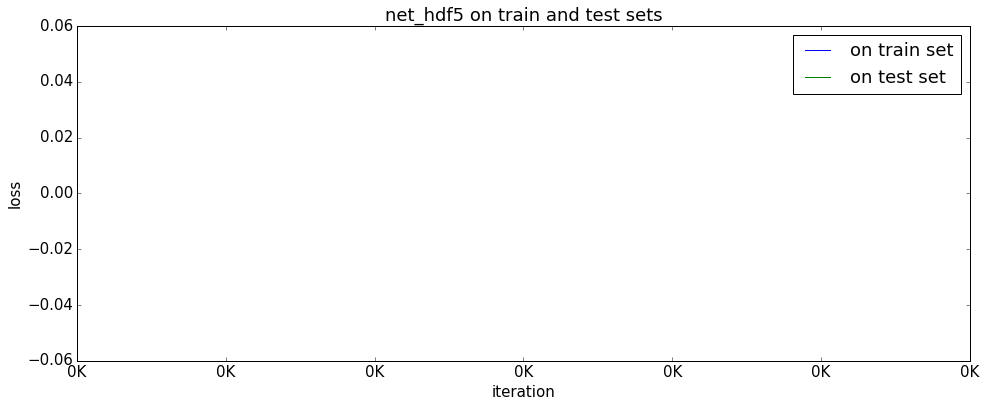

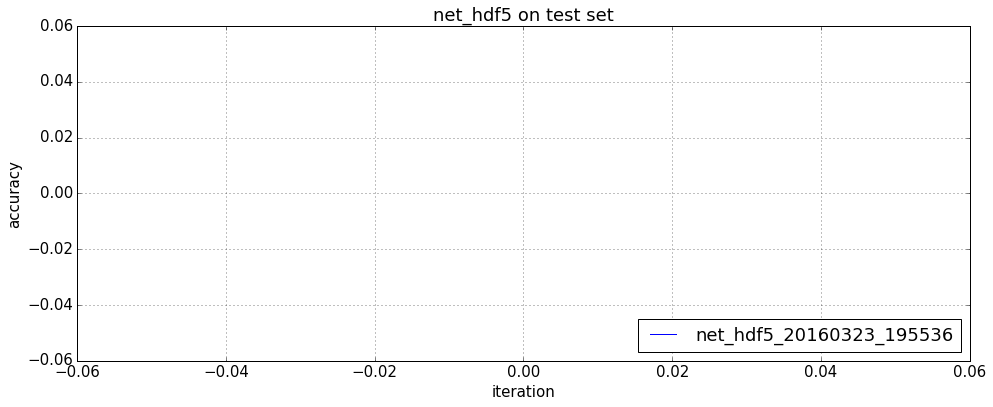

In [15]:
print_learning_curve("net_hdf5", "logs/net_hdf5_20160323_195536.log", "essai")